In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from einops.layers.torch import Rearrange
from einops import rearrange

from typing import Any, Dict, Tuple, Optional
from game_mechanics import GoEnv, choose_move_randomly, load_pkl, play_go, save_pkl
from tqdm.notebook import tqdm

from functools import partial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class GoError(Exception):
    pass

In [3]:
def choose_move(observation, legal_moves, neural_network: nn.Module) -> int:
    probs, value = neural_network(observation, legal_moves)
    probs = probs[0].cpu().detach().numpy()
    move = np.random.choice(range(82), p=probs)
    return move

def random_move(observation, legal_moves):
    return random.choice([m for m in legal_moves])

In [128]:
class AlphaGoZeroBatch(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            Rearrange('b w h -> b 1 w h'),
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=100, out_channels=1, kernel_size=1),
            nn.LeakyReLU(),
            Rearrange('b c w h -> b (c w h)')
        )
        
        self.tower1 = nn.Sequential(
            nn.Linear(81,100),
            nn.LeakyReLU(),
            nn.Linear(100,82)
        )
        
        self.tower2 = nn.Sequential(
            nn.Linear(81,1),
            nn.Tanh()
        ) 


    def forward(self, x, legal_moves):            
        illegal = lambda legal: [move not in legal for move in range(82)]
        mask = torch.stack([torch.as_tensor(illegal(lm)) for lm in legal_moves])
        # remove option for pass, unless only move:
        mask[[len(lm) != 1 for lm in legal_moves], 81] = 1
        x = self.stem(x)
        x1 = self.tower1(x)
        x1 = x1.masked_fill(mask, -torch.inf)
        x1 = F.softmax(x1, dim=-1)
        x2 = self.tower2(x)
        return x1, x2

In [ ]:
class MaskedPolicy(nn.module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            Rearrange('b w h -> b 1 w h'),
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=100, out_channels=1, kernel_size=1),
            nn.LeakyReLU(),
            Rearrange('b c w h -> b (c w h)'),
            nn.Linear(100, 82)
        )
        
    def forward(self, x, legal_moves):
        illegal = lambda legal: [move not in legal for move in range(82)]
        mask = torch.stack([torch.as_tensor(illegal(lm)) for lm in legal_moves])
        # remove option for pass, unless only move:
        mask[[len(lm) != 1 for lm in legal_moves], 81] = 1
        x = self.net(x)
        x = x.masked_fill(mask, -torch.inf)
        return F.softmax(x)
    
class VNet(nn.Module):
    def __init__(self):
        super().__init__()
    
policy = MaskedPolicy()


In [272]:
def normalize(observation: np.ndarray) -> torch.Tensor:
    return torch.as_tensor(observation, dtype=torch.float32)

In [189]:
opponent_choose_move = random_move
game_speed_multiplier=1000000
render=False
verbose=False
env = GoEnv(
    opponent_choose_move,
    verbose=verbose,
    render=render,
    game_speed_multiplier=game_speed_multiplier,
)


metrics = []
test_eval_size = []

num_episodes = 10_000
num_test_episodes = 25
block_train_episodes = 100
gamma = 0.98
lamda = 0.9
total_score = 0
total_played = 0
train_rewards = []
train_losses = {
    'policy': [],
    'value': []
}


memory = 2000
batch_size = 20
gradient_steps = 5

In [274]:
def demean(vector, dim=1, eps=1e-5):
    '''
    convert to mean 0, std 1
    '''
    vector = torch.as_tensor(vector, dtype=torch.float32)
    vector = vector - vector.mean(axis=dim)
    vector = vector / (vector.std(axis=dim) + eps)
    return vector

In [279]:
import stable_baselines3 as sb

In [280]:
sb.common.env_checker.check_env(env)

AssertionError: Your environment must inherit from the gym.Env class cf https://github.com/openai/gym/blob/master/gym/core.py

In [ ]:
check_env()

In [275]:
erm = EpisodeReplayMemory(gamma, lamda)
agzb = AlphaGoZeroBatch()
optimizer = torch.optim.AdamW(agzb.parameters(), lr=0.001)
experiment_name = 'PPO_v2' # actually change to PPO
experiment_name = 'PPO_v3' # normalize gaes within batch


for episode in tqdm(range(num_episodes)):
    old_observation, reward, done, info = env.reset()
    old_observation = normalize(old_observation)
    observation = old_observation
    legal_moves = info['legal_moves']
    policy_losses = []
    value_losses = []
    entropy_losses = []
    while not done:
        probs, value = agzb(rearrange(old_observation, 'w h -> 1 w h'), legal_moves = [legal_moves])
        chosen_move = np.random.choice(range(0,82), p=probs[0].detach().numpy())
        observation, reward, done, info = env.step(chosen_move)
        observation = normalize(observation)
        
        erm.append({
            'old_observation': [old_observation],
            'observation': [observation],
            'reward': reward,
            'done': done,
            'old_legal_moves': [legal_moves],
            'legal_moves': [info['legal_moves']],
            'chosen_move': chosen_move,
            'value': value.item()
        })
        old_observation = observation
        legal_moves = info['legal_moves']
        
    if len(erm) >= memory:
        data = erm.sample(batch_size)
        old_probs, old_values = agzb(data['old_observation'], data['old_legal_moves'])
        loss_v = F.smooth_l1_loss(old_values[:,0], data['gae'][0])
        optimizer.zero_grad()
        loss_v.backward()
        optimizer.step()
        
        epsilon = 0.01
        old_probs = old_probs[range(batch_size), data['chosen_move'].long()].detach()
        for step in range(gradient_steps):
#             print('========')
#             print('making a grad step...')
            new_probs = agzb(data['old_observation'], data['old_legal_moves'])[0]
            new_probs = new_probs[range(batch_size), data['chosen_move'].long()]
#             print(f'unclipped prob_ratio: {new_probs / old_probs}')
            prob_ratio = new_probs / old_probs
            prob_ratio = torch.clamp(prob_ratio, 1-epsilon, 1+epsilon)
#             print(f'after clipping: {prob_ratio}')
            loss_policy = (- prob_ratio * demean(data['gae'])).sum()
#             print(f'loss: {loss_policy.item()}')
            optimizer.zero_grad()
            loss_policy.backward()
            optimizer.step()
            old_probs = new_probs.detach()
    
    
#         for step in range(gradient_steps):
# #             loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])
# #             loss_entropy = -entropy(probs)
#             loss_policy = 3
#             loss = loss_v + loss_policy.sum() # + loss_entropy.sum()
#             optimizer.zero_grad()
#             loss.backward()
#             nn.utils.clip_grad_norm_(agzb.parameters(), 0.1)
#             if torch.isnan(agzb.stem[1].weight.grad).sum() == 0:
#                 optimizer.step()
#             else:
#                 print('==============')
#                 print(loss_v.sum().item(), loss_policy.sum().item(), loss_entropy.sum().item())
#                 print(probs[range(batch_size), data['chosen_move'].long()])
#                 print(-torch.log(probs[range(batch_size), data['chosen_move'].long()]))
#                 print(data['gae'])
#                 print('==============')
#                 raise GoError


#         entropy_losses.append(loss_entropy.sum().item())
        value_losses.append(loss_v.sum().item())
        policy_losses.append(loss_policy.sum().item())


        # pop data
        erm.pop(len(erm) - memory)

#             print(rearrange(agzb.stem[1].weight.grad, 'win wout w h -> (win wout w h)'))
            

        
# #     # log stuff
#     train_rewards.append(reward)
        
#     if episode % block_train_episodes == 0:
#         rewards = []
#         for ep in range(num_test_episodes):
#             observation, reward, done, info = env.reset()
#             while not done:
#                 legal_moves = info['legal_moves']
#                 observation = normalize(observation)
#                 probs, value = agzb(rearrange(observation, 'w h -> 1 w h'), legal_moves = [legal_moves])
#                 chosen_move = np.random.choice(range(0,82), p=probs[0].detach().numpy())
#                 observation, reward, done, info = env.step(chosen_move)
#             rewards.append(reward)
           
#         test_wr = sum([r == 1 for r in rewards])/num_test_episodes
#         test_score = sum(rewards)/num_test_episodes
#         test_ties = sum([r == 0 for r in rewards])/num_test_episodes
        
#         train_wr = sum([r == 1 for r in train_rewards])/block_train_episodes
#         train_score = sum(train_rewards)/block_train_episodes
#         train_ties = sum([r == 0 for r in train_rewards])/block_train_episodes
#         train_rewards = []
#         metrics.append({'test_win_rate': test_wr,
#                         'test_score': test_score,
#                         'test_ties': test_ties,
#                         'train_win_rate': train_wr,
#                         'train_score': train_score,
#                         'train_ties': train_ties,
#                         'episode': episode,
#                         'total_score': total_score,
#                         'total_played': total_played,
#                         'train_loss_policy': sum(policy_losses)/(len(policy_losses)+1),
#                         'train_loss_value': sum(value_losses)/(len(value_losses)+1)
#                        })

#         pd.DataFrame(metrics).to_csv(f'logs/{experiment_name}_{episode}.csv')
#         train_losses = {
#             'policy': [],
#             'value': []
#         }

#     total_score += reward
#     total_played += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

ValueError: probabilities contain NaN

tensor([[0.9000, 0.9000, 1.0000, 0.9000, 1.0016, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 0.9000, 1.1000,
         0.9000, 0.9000]], grad_fn=<ClampBackward1>)

In [231]:
epsilon = 0.1
data = erm.sample(batch_size)
old_probs, old_values = agzb(data['old_observation'], data['old_legal_moves'])
loss_v = F.smooth_l1_loss(values[:,0], data['gae'][0])
new_probs = old_probs[range(batch_size), data['chosen_move'].long()]
old_probs = old_probs[range(batch_size), data['chosen_move'].long()].detach()
for step in range(gradient_steps):
    print(new_probs / old_probs)
    prob_ratio = new_probs / old_probs
    prob_ratio = torch.clamp(prob_ratio, 1-epsilon, 1+epsilon)
    loss_policy = (- prob_ratio * data['gae']).sum()
    print(f'loss: {loss_policy.item()}')
    optimizer.zero_grad()
    loss_policy.backward()
    optimizer.step()
    old_probs = new_probs.detach()
    new_probs = agzb(data['old_observation'], data['old_legal_moves'])[0][range(batch_size), data['chosen_move'].long()]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], grad_fn=<DivBackward0>)
loss: 0.7653517127037048
tensor([[0.9720, 0.9970, 0.9700, 0.9837, 1.0023, 0.9953, 0.9948, 0.9936, 0.9894,
         0.9932, 0.9903, 1.0027, 0.9997, 1.0015, 1.0003, 1.0053, 1.0035, 0.9942,
         0.9951, 0.9949]], grad_fn=<DivBackward0>)
loss: 0.7429934144020081
tensor([[0.9366, 0.9889, 0.9491, 1.0005, 0.9948, 0.9837, 1.0023, 1.0003, 0.9814,
         0.9876, 0.9469, 1.0244, 0.9940, 1.0140, 0.9873, 0.9945, 1.0007, 0.9981,
         0.9693, 1.0111]], grad_fn=<DivBackward0>)
loss: 0.7247187495231628
tensor([[0.8657, 0.9967, 0.9061, 1.0416, 0.9956, 0.9767, 0.9880, 1.0071, 0.9768,
         0.9639, 0.8841, 0.9898, 1.0312, 0.9976, 0.9499, 0.9425, 0.9947, 0.9710,
         0.9085, 1.0140]], grad_fn=<DivBackward0>)
loss: 0.6947099566459656
tensor([[0.8709, 0.9938, 0.8246, 1.0224, 1.0266, 0.9647, 0.9883, 1.0124, 0.9450,
         0.9330, 0.8775, 0.9900, 1.0310, 0.9942, 0.9422,

tensor([[1.0060, 1.0904, 1.1360, 0.9289, 1.0531, 1.4913, 0.9691, 0.9812, 0.8563,
         1.0044, 0.9955, 0.9851, 0.9150, 1.0844, 0.9109, 0.9422, 0.9792, 0.9196,
         0.9358, 0.9541]], grad_fn=<DivBackward0>)
loss: -0.30770641565322876
tensor([[0.9941, 1.1003, 1.1780, 0.8801, 1.0263, 1.4923, 0.9475, 0.9663, 0.8130,
         0.9945, 0.9749, 0.9696, 0.8817, 1.0771, 0.8796, 0.9149, 0.9567, 0.8714,
         0.9151, 0.9125]], grad_fn=<DivBackward0>)
loss: -0.3103961646556854
tensor([[0.9813, 1.1364, 1.2316, 0.8379, 1.0006, 1.3825, 0.9223, 0.9419, 0.7448,
         0.9784, 0.9522, 0.9412, 0.8473, 1.0560, 0.8356, 0.8937, 0.9313, 0.8097,
         0.8881, 0.8758]], grad_fn=<DivBackward0>)
loss: -0.29622897505760193
tensor([[0.9644, 1.2121, 1.3059, 0.7793, 0.9695, 1.1946, 0.8975, 0.9138, 0.6705,
         0.9601, 0.9238, 0.9042, 0.7977, 1.0209, 0.7944, 0.8580, 0.8976, 0.7395,
         0.8657, 0.8208]], grad_fn=<DivBackward0>)
loss: -0.27125832438468933
tensor([[0.9289, 1.2767, 1.3419, 0.7127, 

In [214]:
loss_policy

tensor([[ 5.2582e-04,  8.0896e-01,  6.5621e-04,  1.4040e-03,  5.9832e-04,
          1.0874e-03,  1.8557e-04,  5.9848e-04,  5.5689e-03,  1.0085e-03,
          7.1289e-04,  6.2720e-04, -2.3690e-03,  9.1954e-04,  1.6345e-02,
          1.7020e-04, -2.3217e-04,  8.4265e-05,  6.7754e-04,  5.0323e-04]],
       grad_fn=<MulBackward0>)

In [205]:
loss_v

tensor(0.2118, grad_fn=<SmoothL1LossBackward0>)

In [207]:
old_probs[range(batch_size), data['chosen_move'].long()]

tensor([[0.0275, 0.0203, 0.1484, 0.0185, 0.1920, 0.0140, 0.2300, 0.1008, 0.1252,
         0.0236, 0.0782, 0.0609, 0.0778, 0.0263, 0.0951, 0.0212, 0.0275, 0.1023,
         0.0737, 0.1652]], grad_fn=<IndexBackward0>)

In [ ]:
for step in range(gradient_steps):
#             loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])
#             loss_entropy = -entropy(probs)
    loss_policy = 3
    loss = loss_v + loss_policy.sum() # + loss_entropy.sum()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(agzb.parameters(), 0.1)
    if torch.isnan(agzb.stem[1].weight.grad).sum() == 0:
        optimizer.step()
    else:
        print('==============')
        print(loss_v.sum().item(), loss_policy.sum().item(), loss_entropy.sum().item())
        print(probs[range(batch_size), data['chosen_move'].long()])
        print(-torch.log(probs[range(batch_size), data['chosen_move'].long()]))
        print(data['gae'])
        print('==============')
        raise GoError


In [183]:
erm = EpisodeReplayMemory(gamma, lamda)
agzb = AlphaGoZeroBatch()
optimizer = torch.optim.AdamW(agzb.parameters(), lr=0.001)
experiment_name = 'PPO_v0'

for episode in tqdm(range(num_episodes)):
    old_observation, reward, done, info = env.reset()
    old_observation = normalize(old_observation)
    observation = old_observation
    legal_moves = info['legal_moves']
    policy_losses = []
    value_losses = []
    entropy_losses = []
    while not done:
        probs, value = agzb(rearrange(observation, 'w h -> 1 w h'), legal_moves = [legal_moves])
        chosen_move = np.random.choice(range(0,82), p=probs[0].detach().numpy())
        observation, reward, done, info = env.step(chosen_move)
        observation = normalize(observation)
        
        erm.append({
            'old_observation': [old_observation],
            'observation': [observation],
            'reward': reward,
            'done': done,
            'old_legal_moves': [legal_moves],
            'legal_moves': [info['legal_moves']],
            'chosen_move': chosen_move,
            'value': value.item()
        })
        old_observation = observation
        legal_moves = info['legal_moves']
        
    if len(erm) >= memory:
#         print('making a grad step...')
        data = erm.sample(batch_size)
        probs, values = agzb(data['old_observation'], data['old_legal_moves'])
        loss_v = F.smooth_l1_loss(values[:,0], data['gae'][0])
        loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])
        loss_entropy = -entropy(probs)
        loss = loss_v + loss_policy.sum() # + loss_entropy.sum()
        value_losses.append(loss_v.sum().item())
        policy_losses.append(loss_policy.sum().item())
        entropy_losses.append(loss_entropy.sum().item())




        if loss_policy.sum().item() < -1000:
            raise GoError

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(agzb.parameters(), 0.1)
        if torch.isnan(agzb.stem[1].weight.grad).sum() == 0:
            optimizer.step()
        else:
            print('==============')
            print(loss_v.sum().item(), loss_policy.sum().item(), loss_entropy.sum().item())
            print(probs[range(batch_size), data['chosen_move'].long()])
            print(-torch.log(probs[range(batch_size), data['chosen_move'].long()]))
            print(data['gae'])
            print('==============')
            raise GoError

        # pop data
        erm.pop(len(erm) - memory)

#             print(rearrange(agzb.stem[1].weight.grad, 'win wout w h -> (win wout w h)'))
            

        
#     # log stuff
    train_rewards.append(reward)
        
    if episode % block_train_episodes == 0:
        rewards = []
        for ep in range(num_test_episodes):
            observation, reward, done, info = env.reset()
            while not done:
                legal_moves = info['legal_moves']
                observation = normalize(observation)
                probs, value = agzb(rearrange(observation, 'w h -> 1 w h'), legal_moves = [legal_moves])
                chosen_move = np.random.choice(range(0,82), p=probs[0].detach().numpy())
                observation, reward, done, info = env.step(chosen_move)
            rewards.append(reward)
           
        test_wr = sum([r == 1 for r in rewards])/num_test_episodes
        test_score = sum(rewards)/num_test_episodes
        test_ties = sum([r == 0 for r in rewards])/num_test_episodes
        
        train_wr = sum([r == 1 for r in train_rewards])/block_train_episodes
        train_score = sum(train_rewards)/block_train_episodes
        train_ties = sum([r == 0 for r in train_rewards])/block_train_episodes
        train_rewards = []
        metrics.append({'test_win_rate': test_wr,
                        'test_score': test_score,
                        'test_ties': test_ties,
                        'train_win_rate': train_wr,
                        'train_score': train_score,
                        'train_ties': train_ties,
                        'episode': episode,
                        'total_score': total_score,
                        'total_played': total_played,
                        'train_loss_policy': sum(policy_losses)/(len(policy_losses)+1),
                        'train_loss_value': sum(value_losses)/(len(value_losses)+1)
                       })

        pd.DataFrame(metrics).to_csv(f'logs/{experiment_name}_{episode}.csv')
        train_losses = {
            'policy': [],
            'value': []
        }

    total_score += reward
    total_played += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

GoError: 

In [77]:
len(erm)

2000

In [13]:
policy_losses

[-0.0037301385309547186,
 -0.024941865354776382,
 0.006949669681489468,
 0.002547965617850423,
 -0.0005118795670568943,
 -0.010659327730536461,
 0.00045812781900167465,
 0.0015979387098923326,
 0.004741208627820015,
 0.005046558566391468,
 -0.03361545503139496,
 0.015168051235377789,
 0.005205255467444658,
 -0.022774431854486465,
 0.01015450805425644,
 -0.008700385689735413,
 -0.0019155567279085517,
 -0.01162044983357191,
 -0.01042257621884346,
 0.006771334912627935,
 -0.00803698506206274,
 0.002187971491366625,
 0.00998406670987606,
 -0.008172986097633839,
 0.0009817909449338913,
 0.009564206935465336,
 0.0047758230939507484,
 -0.011998648755252361,
 -0.017856277525424957,
 0.0016945855459198356,
 5.4521020501852036e-05,
 -0.01721285469830036,
 0.00843917578458786,
 -0.015443354845046997,
 0.006355703808367252,
 -0.0013247529277577996,
 0.0026575231458991766,
 0.003212957875803113,
 -0.006097408942878246,
 -0.0067151449620723724,
 0.011311236768960953,
 -0.023048035800457,
 0.01154179

In [11]:
legal_moves

array([ 3, 23, 34, 38, 58, 65, 76, 81])

In [671]:
def gae(rewards, values, successor_values, gamma, lamda):
    N = len(rewards)
    deltas = rewards + gamma*successor_values - values
    print(deltas)
    gamlam = gamma * lamda
    print(gamlam)
    gamlam_geo_series = torch.as_tensor([gamlam**i for i in range(N)])*(1-gamlam)
    print(gamlam_geo_series.sum())
    print(gamlam_geo_series)
    full_gamlam_matrix = torch.stack([torch.roll(gamlam_geo_series, shifts=n) for n in range(N)])
    full_gamlam_matrix = torch.triu(full_gamlam_matrix)
    # make sure it sums to one:
    # (by making the term for the last value be 1 - sum(all other terms))
    full_gamlam_matrix[:,-1] = 1 - full_gamlam_matrix[:,:-1].sum(axis=1)
    return full_gamlam_matrix @ deltas

In [672]:
gae(erm.data.reward[-76:], erm.data.value[-76:], np.append(erm.data.value[-75:].values, 0), 0.98, 0.9)

79090cb7-a79f-4187-b318-6bee19e07106    0.053663
54a427cd-0d1e-4e3c-aed6-c32cd130e8ca    0.023148
044beaba-81ac-407e-8405-1f78e3f71f66   -0.033101
1269371b-be6d-42de-adda-9ef1d35b8d38    0.028446
800bc267-4783-4a39-9766-51ad3dabeb79    0.062310
                                          ...   
8d90c664-89fa-4aa7-9b70-20eee6e5d3da   -0.047355
200e179d-607b-4afe-85d1-4c3192a8a512   -0.081588
1c52109c-577d-47ad-8052-82103ccedc8c   -0.272351
c951121d-576b-43ba-91b8-310ce9fda765   -0.110339
c760a1cd-c5dd-438c-af02-303ff56d3497   -0.793496
Length: 76, dtype: float64
0.882
tensor(0.9999)
tensor([1.1800e-01, 1.0408e-01, 9.1795e-02, 8.0963e-02, 7.1410e-02, 6.2983e-02,
        5.5551e-02, 4.8996e-02, 4.3215e-02, 3.8115e-02, 3.3618e-02, 2.9651e-02,
        2.6152e-02, 2.3066e-02, 2.0344e-02, 1.7944e-02, 1.5826e-02, 1.3959e-02,
        1.2312e-02, 1.0859e-02, 9.5775e-03, 8.4474e-03, 7.4506e-03, 6.5714e-03,
        5.7960e-03, 5.1121e-03, 4.5088e-03, 3.9768e-03, 3.5075e-03, 3.0936e-03,
        2.728

array([ 0.01706675,  0.01217071,  0.01070203,  0.01656227,  0.01497237,
        0.00863929,  0.00485988, -0.00309762, -0.00895774, -0.01382866,
       -0.00630588, -0.01161645, -0.01748861, -0.00752516, -0.01405457,
       -0.0051386 , -0.00090681,  0.00246415,  0.00802777,  0.00237488,
        0.00107258,  0.00914282,  0.00737539,  0.00365904,  0.00518325,
        0.01056112,  0.01196938,  0.00168064,  0.00568278, -0.00539965,
       -0.00521241, -0.01592977, -0.01018809, -0.00608239, -0.00583005,
       -0.00286979, -0.0102057 , -0.01184584, -0.0151518 , -0.01719426,
       -0.02541254, -0.02884286, -0.03223855, -0.0393263 , -0.04145166,
       -0.04955144, -0.05483385, -0.0514251 , -0.04460295, -0.04899038,
       -0.05018361, -0.04704022, -0.07603612, -0.0700813 , -0.08826283,
       -0.09690747, -0.10663619, -0.11393048, -0.11967866, -0.12305002,
       -0.12550825, -0.13013705, -0.16037103, -0.17989618, -0.19420775,
       -0.21929876, -0.24109841, -0.30766229, -0.33327461, -0.39

In [591]:
policy_losses

[-27.440486907958984,
 -21.824899673461914,
 -27.161766052246094,
 -0.6968467235565186,
 -6.4027018547058105,
 -61.83473587036133,
 -19.494089126586914,
 -52.11186599731445,
 -14.539194107055664,
 -22.4394474029541,
 -25.420284271240234,
 -17.10361671447754,
 -53.09296798706055,
 -26.88081932067871,
 -15.251133918762207,
 -27.69683074951172,
 -37.522422790527344,
 -33.41025924682617,
 -4.652161598205566,
 -36.31564712524414,
 -17.745750427246094,
 -37.966644287109375,
 -34.613372802734375,
 -22.81201171875,
 -56.3080940246582,
 -20.445175170898438,
 -60.870582580566406,
 -45.934513092041016,
 -10.51439380645752,
 -56.14714431762695,
 -57.362060546875,
 -73.95291137695312,
 -33.51780700683594,
 -31.75788688659668,
 -20.893056869506836,
 -2.9542171955108643,
 -58.07902908325195,
 -27.55059242248535,
 -38.236083984375,
 -30.0587158203125,
 -63.049713134765625,
 -44.49853515625,
 -32.04090118408203,
 -96.06962585449219,
 -21.764240264892578,
 -49.9351806640625,
 -84.3717041015625]

In [592]:
erm.data.gae

099cc42a-718f-4ce8-a593-9110b722bf7f    0.131994
69ee8cf6-9250-4cc9-ba96-4b8e5bae1da0    0.133866
68729b4e-a992-40e5-a658-c1fe4ca56e55    0.135989
7ae63035-6d53-4315-98df-59e98551e5be    0.138395
b593c584-ff9a-43d0-aab7-5cd646043e52    0.141124
                                          ...   
5166a343-993b-4f5f-913f-8b23e32a4483   -0.651756
a52e7e77-0f37-4705-a5be-68700090c52f   -0.723166
72a48304-3e81-41d7-8827-8822d7b6237c   -0.804129
b8ed51ce-187a-4f0b-a446-57fd99ca0497   -0.895924
e6dc0f1d-7f09-414c-84ad-0744c4498a6b   -1.000000
Name: gae, Length: 2000, dtype: float64

In [579]:
values = erm.data.value
successor_values = np.append(erm.data.value[1:], 0)
rewards = erm.data.reward

In [580]:
gae(rewards, values, successor_values, 0.98, 0.9)

array([-0.11800009, -0.11800003, -0.11800003, ..., -0.80412894,
       -0.89592397, -1.        ])

In [581]:
len(rewards)

2000

In [ ]:
(1-1/n) + (1-1/n)**2 + ... + (1-1/n)**inf = 



In [583]:
    N = len(rewards)
    deltas = rewards + gamma*successor_values - values
    print(deltas)
    gamlam = gamma * lamda
    print(gamlam)
    gamlam_geo_series = torch.as_tensor([gamlam**i for i in range(1,N+1)])*(1-gamlam)
    print(gamlam_geo_series)
    full_gamlam_matrix = torch.stack([torch.roll(gamlam_geo_series, shifts=n) for n in range(N)])
    full_gamlam_matrix = torch.triu(full_gamlam_matrix)
    # make sure it sums to one:
    # (by making the term for the last value be 1 - sum(all other terms))
    print(full_gamlam_matrix)
    full_gamlam_matrix[:,-1] = 1 - full_gamlam_matrix[:,:-1].sum(axis=1)
    print(full_gamlam_matrix)
#     return full_gamlam_matrix @ rewards

36ded7c1-340a-40b3-b3ea-b5f8a9b2db4b   -0.000590
7b3c73a6-e499-42f8-801d-b3efd2122f13    0.001796
6ec5f132-5cf2-4a46-b6e3-913e01d77c66    0.001113
1be75976-9f54-4f80-8f66-b4a4fb796d3e    0.001062
ba083112-d85a-455f-b12e-4d1041a0c304    0.002020
                                          ...   
df94ac6d-03bf-4ca1-b666-a5d5618b4815    0.066126
e26e7b0a-055b-4b97-a2df-93fc49010861   -0.145267
d869a443-c1a2-4af3-8ded-0c124258cd5a    0.035698
60e064ba-a622-4760-80a0-07cedb2cc4f3    0.035179
c8d02e7d-cce5-4ff5-a4b5-73b86f3379d4   -0.942783
Length: 2000, dtype: float64
0.882
tensor([0.1041, 0.0918, 0.0810,  ..., 0.0000, 0.0000, 0.0000])
tensor([[0.1041, 0.0918, 0.0810,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1041, 0.0918,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1041,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1041, 0.0918, 0.0810],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1041, 0.0918],
        [0.0000, 0.0000, 0.000

In [507]:
import matplotlib.pyplot as plt

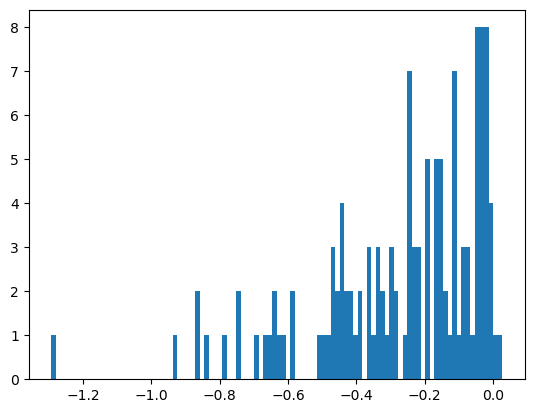

In [678]:
plt.hist(policy_losses, bins=100)
plt.show()

In [692]:
rearrange(agzb.stem[1].weight.grad, 'win wout w h -> (win wout w h)')

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])


In [518]:
data['chosen_move']

tensor([[81., 81., 61., 79., 81., 81., 51., 60.]])

In [525]:
data = erm.sample(batch_size)
probs, values = agzb(data['old_observation'], data['old_legal_moves'])

In [529]:
x = agzb.stem(data['old_observation'])
x1 = agzb.tower1(x)

In [537]:
agzb.stem

Sequential(
  (0): Rearrange('b w h -> b 1 w h')
  (1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))
  (6): ReLU()
  (7): Rearrange('b c w h -> b (c w h)')
)

In [548]:
list(agzb.stem.get_submodule('1').parameters())[0]

Parameter containing:
tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, 

In [541]:
x_temp = agzb.stem.get_submodule('0')(data['old_observation'])
x_temp = agzb.stem.get_submodule('1')(x_temp)
x_temp

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, n

In [532]:
data['old_observation']

tensor([[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 0.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  1.,  1.,  1.,  1.,  1.,  0., -1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]],

        [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  

In [527]:
probs[range(batch_size), data['chosen_move'].long()]

tensor([[nan, nan, nan, nan, nan, nan, nan, nan]], grad_fn=<IndexBackward0>)

In [528]:
data['gae']

tensor([[-0.1523, -1.0000, -0.5100, -0.0392, -0.0525, -0.0400, -0.0393, -0.0408]])

In [ ]:

            with torch.no_grad():
                new_probs, new_values = agzb(data['observation'], data['legal_moves'])
            
#             loss_v = F.smooth_l1_loss(values[:,0], (data['reward'] + gamma*new_values[0]*(1-data['done']))[0])
            loss_v = F.smooth_l1_loss(values[:,0], data['gae'][0])
            loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])
            loss = (loss_v + loss_policy).sum()
            value_losses.append(loss_v.sum().item())
            policy_losses.append(loss_policy.sum().item())
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agzb.parameters(), 10)
            optimizer.step()
            

In [516]:
probs[range(batch_size), data['chosen_move'].long()]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [524]:
probs.shape

torch.Size([1, 82])

In [521]:
probs[:, data['chosen_move'].long()]

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan]]], grad_fn=<IndexBackward0>)

In [ ]:
loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])


In [515]:
loss_policy

tensor([[ 0.0000,  0.0000,  0.0000, -0.7856,  0.0000,  0.0000, -2.9664, -3.6239]],
       grad_fn=<MulBackward0>)

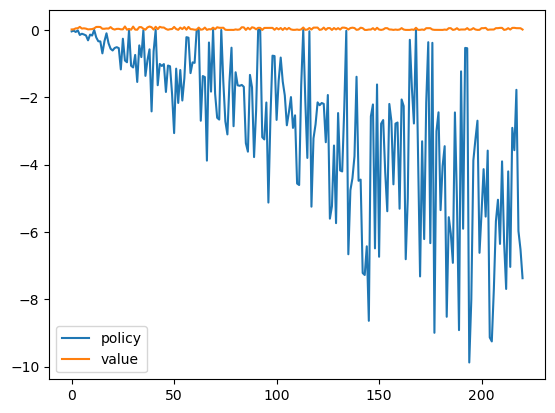

In [513]:
plt.plot(policy_losses)
plt.plot(value_losses)
plt.legend(['policy', 'value'])
plt.show()

In [505]:
value_losses

[0.014642732217907906,
 0.018630705773830414,
 0.04683767631649971,
 0.050856832414865494,
 0.09128890186548233,
 0.04108111560344696,
 0.048889387398958206,
 0.0391571968793869,
 0.01632932387292385,
 0.02227049507200718,
 0.025274699553847313,
 0.046861693263053894,
 0.08866816759109497,
 0.09038940817117691,
 0.08704598248004913,
 0.0345674529671669,
 0.035304196178913116,
 0.04400236904621124,
 0.04056328162550926,
 0.08419870585203171,
 0.03162689507007599,
 0.011311449110507965,
 0.03195742145180702,
 0.03313601016998291,
 0.01846647635102272,
 0.018551141023635864,
 0.1031537652015686,
 0.007746596820652485,
 0.03015638329088688,
 0.007393420673906803,
 0.09939071536064148,
 0.010102551430463791,
 0.007017123978585005,
 0.08444192260503769,
 0.08278614282608032,
 0.035661544650793076,
 0.007890569977462292,
 0.07533761858940125,
 0.10149736702442169,
 0.0802885964512825,
 0.011148294433951378,
 0.09487415850162506,
 0.023402292281389236,
 0.09263225644826889,
 0.0727292820811271

In [502]:
loss_v = F.smooth_l1_loss(values[:,0], data['gae'][0])
# loss_policy = -torch.log(probs[range(batch_size), data['chosen_move'].long()])*(data['gae'])

In [503]:
loss_v

tensor(0.0526, grad_fn=<SmoothL1LossBackward0>)

In [494]:
values[:,0].shape

torch.Size([8])

In [497]:
data['gae'][0]

tensor([-0.0946, -0.0457, -1.0000, -0.0664, -0.0396, -0.1523, -0.0408, -0.0525])

In [487]:
data

{'old_observation': tensor([[[ 0., -1., -1., -1., -1.,  0., -1.,  0.,  0.],
          [ 1., -1.,  0.,  0.,  0., -1.,  1.,  0.,  1.],
          [-1.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.],
          [-1.,  0.,  1.,  1.,  1., -1., -1.,  0.,  0.],
          [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  1.],
          [ 0., -1.,  0.,  1.,  1.,  0.,  1.,  0., -1.],
          [ 1.,  1.,  1.,  0.,  0.,  0.,  0., -1.,  0.],
          [ 0., -1.,  0.,  0., -1.,  0., -1.,  0.,  0.],
          [ 0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.]],
 
         [[-1., -1., -1., -1., -1.,  0., -1.,  0.,  0.],
          [-1., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
          [-1., -1.,  0.,  0., -1., -1.,  0.,  0., -1.],
          [-1., -1.,  0.,  0.,  0., -1., -1., -1., -1.],
          [-1., -1., -1.,  0.,  0., -1., -1., -1., -1.],
          [ 0., -1.,  0.,  0.,  0., -1., -1., -1., -1.],
          [ 0.,  0.,  1.,  0.,  0.,  0., -1., -1.,  0.],
          [ 0.,  0.,  0., -1., -1.,  0., -1., -1., -1.],
         

In [469]:
gae(erm.data.reward, erm.data.value, np.append(erm.data.value[1:],0), 0.98, 0.5)

array([-0.03921694, -0.03921831, -0.03922087, -0.03922635, -0.03923744,
       -0.03925991, -0.03930593, -0.03939974, -0.03959131, -0.03998232,
       -0.04078025, -0.04240865, -0.0457319 , -0.05251414, -0.06635547,
       -0.094603  , -0.15225095, -0.26989996, -0.50999999, -1.        ])

In [449]:
loss_v = F.smooth_l1_loss(values[:,0], (data['reward'] + gamma*new_values[0]*(1-data['done']))[0])

In [450]:
loss_v

tensor(0., grad_fn=<SmoothL1LossBackward0>)

In [452]:
(data['reward'] + gamma*new_values[0]*(1-data['done']))[0]

tensor([-1., -1., -1., -1., -1., -1., -1., -1.])

In [444]:
values[:,0]

tensor([-1., -1., -1., -1., -1., -1., -1., -1.], grad_fn=<SelectBackward0>)

In [448]:
(data['reward'] + gamma*new_values[0]*(1-data['done'])).shape

torch.Size([1, 8])

In [396]:
data['reward'] + gamma*new_values[0]*(1-data['done'])

tensor([[-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800]])

In [391]:
erm.data

,old_observation,observation,reward,done,old_legal_moves,legal_moves,chosen_move,value,gae
862e39d4-6f9c-4bc4-a838-9a1c594a95ab,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[11, 12, 18, 19, 20, 21, 28, 29, 36, 39, 40, 4...","[12, 18, 19, 20, 21, 28, 29, 36, 39, 40, 45, 4...",11,-0.069335,-0.000001
9bc3348b-4070-43ef-a2d5-44617d81011f,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 18, 19, 20, 21, 28, 29, 36, 39, 40, 45, 4...","[12, 18, 19, 20, 28, 29, 36, 39, 40, 45, 46, 4...",65,-0.071543,-0.000003
da7a2bf8-8289-4699-80ad-3a074dbbe4ea,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 18, 19, 20, 28, 29, 36, 39, 40, 45, 46, 4...","[12, 18, 19, 20, 28, 29, 39, 40, 45, 46, 47, 5...",54,-0.077015,-0.000005
7eda99aa-2815-4bb2-932b-16ad460169da,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 18, 19, 20, 28, 29, 39, 40, 45, 46, 47, 5...","[12, 19, 20, 28, 29, 39, 40, 43, 44, 45, 46, 4...",18,-0.080044,-0.000011
f1c2ac54-a3fb-49b4-94f5-8e200a5e6b2d,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 28, 29, 39, 40, 43, 44, 45, 46, 4...","[12, 19, 20, 28, 29, 39, 40, 43, 44, 45, 55, 5...",46,-0.090791,-0.000023
f3b5350c-0cab-4bb0-9775-db381625d74c,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 28, 29, 39, 40, 43, 44, 45, 55, 5...","[12, 19, 20, 28, 29, 39, 40, 55, 58, 59, 64, 6...",45,-0.079023,-0.000046
fbe07421-c362-4fa6-b423-e6f742c648be,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 28, 29, 39, 40, 55, 58, 59, 64, 6...","[12, 19, 20, 29, 39, 40, 55, 58, 59, 64, 67, 7...",74,-0.086739,-0.000094
c9936be4-3731-4128-841a-0c3c6415f698,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 29, 39, 40, 55, 58, 59, 64, 67, 7...","[12, 19, 20, 29, 39, 40, 55, 58, 59, 64, 73, 7...",67,-0.080280,-0.000192
64d810f2-a739-46e7-b059-c96ab9351b6a,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 29, 39, 40, 55, 58, 59, 64, 73, 7...","[12, 19, 20, 29, 39, 40, 55, 58, 59, 75, 77, 81]",73,-0.083239,-0.000391
6dea21b1-ef8c-4d10-bc18-13aec34e8406,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",0.0,False,"[12, 19, 20, 29, 39, 40, 55, 58, 59, 75, 77, 81]","[12, 18, 20, 27, 29, 39, 40, 55, 59, 75, 77, 81]",58,-0.080218,-0.000798


In [390]:
probs[0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<SelectBackward0>)

In [384]:
type(erm.data)

pandas.core.frame.DataFrame

In [385]:
type(erm.current_episode)

pandas.core.frame.DataFrame

In [346]:
data['done']

tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])

In [344]:
data['reward'] + gamma*new_values*(1-data['done'])

tensor([[-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800],
        [-0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800, -0.9800]])

In [323]:
values.shape

torch.Size([10, 1])

In [328]:
(gamma*new_values*(1-data['done'])).shape

torch.Size([10, 10])

In [324]:
new_values.shape

torch.Size([10, 1])

In [325]:
data['reward'].shape

torch.Size([10])

In [321]:
value_losses

[0.007821455597877502,
 0.00784947071224451,
 0.007877429947257042,
 0.00790549349039793,
 3.0834832191467285,
 0.007961610332131386,
 0.007989715784788132,
 0.00801781751215458,
 0.008046022616326809,
 0.008074169978499413,
 0.008102420717477798,
 0.008130612783133984,
 0.008158906362950802,
 0.008187196217477322,
 0.008215482346713543,
 0.008243869990110397,
 0.00827225111424923,
 0.008300629444420338,
 0.008329054340720177,
 0.008357472717761993,
 2.9465503692626953,
 0.008414402604103088,
 0.008442913182079792,
 0.008471472188830376,
 0.008500022813677788,
 0.008528566919267178,
 0.008557159453630447,
 0.008585800416767597,
 0.008614432066679,
 0.008643057197332382,
 0.008671729825437069,
 0.008700449950993061,
 0.008729161694645882,
 0.008757920935750008,
 0.008786670863628387,
 0.008815469220280647,
 0.008844312280416489,
 0.008873148821294308,
 0.00890197604894638,
 0.008930847980082035,
 0.00895976647734642,
 0.008988678455352783,
 0.009017633274197578,
 0.009046580642461777,
 

In [319]:
value_losses

[-1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.999997615814209,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.999997615814209,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -21.799999237060547,
 -1.999997615814209,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.999997615814209,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.9999980926513672,
 -1.7999982833862305,
 -1.9999980926513672,
 -1.9999980926

In [316]:
policy_losses

[-16.35268211364746,
 -16.882858276367188,
 -19.37784767150879,
 -14.741109848022461,
 -20.701602935791016,
 -15.53093433380127,
 -16.250961303710938,
 -13.0906400680542,
 -19.765714645385742,
 -14.130338668823242,
 -18.23744773864746,
 -18.990041732788086,
 -21.608858108520508,
 -20.79874038696289,
 -23.741863250732422,
 -21.764177322387695,
 -23.284482955932617,
 -28.183473587036133,
 -41.98383331298828,
 -61.31343460083008,
 -55.30613327026367,
 -89.18364715576172,
 -120.94459533691406,
 -85.09255981445312,
 -124.34806823730469,
 -152.19947814941406,
 -172.34365844726562,
 -261.9233093261719,
 -226.24478149414062,
 -253.68310546875,
 -203.94873046875,
 -317.4092712402344,
 -290.2842102050781,
 -291.5194396972656,
 -372.82769775390625,
 -446.91717529296875,
 -379.376220703125,
 -513.4480590820312,
 -523.9698486328125,
 -675.8705444335938,
 -847.7994995117188,
 -762.2334594726562,
 -813.22265625,
 -1186.1192626953125,
 -1452.66064453125,
 -1119.3922119140625,
 -1705.62890625,
 -1443.5

In [289]:
probs

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SoftmaxBackward0>)

In [290]:
legal_moves

array([28, 51, 69, 81])

In [291]:
probs, value = agzb(rearrange(observation, 'w h -> 1 w h'), legal_moves = [legal_moves])

In [292]:
probs, value

(tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[nan]], grad_fn=<TanhBackward0>))

In [296]:
illegal = lambda legal: [move not in legal for move in range(82)]
mask = torch.stack([torch.as_tensor(illegal(lm)) for lm in [legal_moves]])
mask[[len(lm) != 1 for lm in [legal_moves]], 81] = 1


In [299]:
x = agzb.stem(rearrange(old_observation, 'w h -> 1 w h'))

In [300]:
x

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
        illegal = lambda legal: [move not in legal for move in range(82)]
        mask = torch.stack([torch.as_tensor(illegal(lm)) for lm in legal_moves])
        # remove option for pass, unless only move:
        mask[[len(lm) != 1 for lm in legal_moves], 81] = 0
        x = self.stem(x)
        x1 = self.tower1(x)
        x1 = x1.masked_fill(mask, -torch.inf)
        x1 = F.softmax(x1, dim=-1)
        x2 = self.tower2(x)
        return x1, x2

In [259]:
legal_moves

array([ 7,  8, 36, 49, 62, 63, 66, 70, 74, 77, 81])

In [258]:
probs

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SoftmaxBackward0>)